In [27]:
%pip install datasets matplotlib numpy scikit-learn sentence_transformers wordcloud -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [12]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import random
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import gc
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, classification_report, accuracy_score

ds = load_dataset("PleIAs/French-PD-Books")

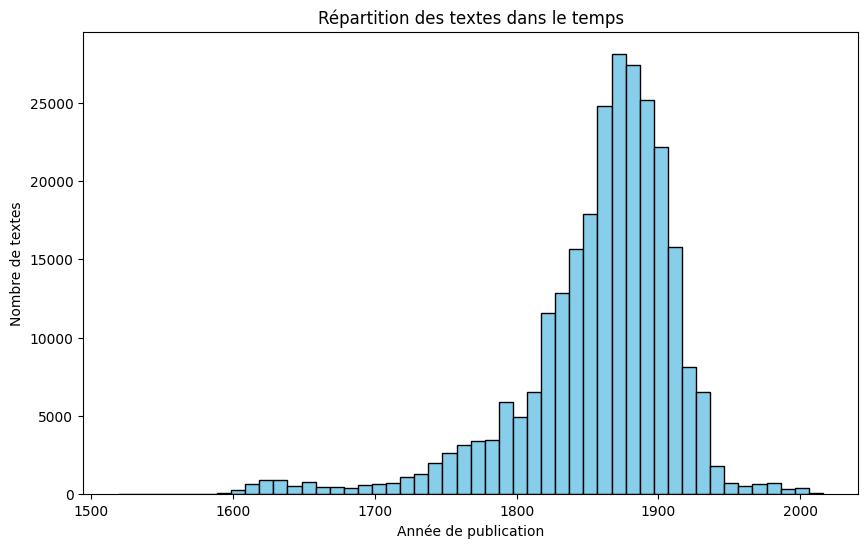

In [13]:
# Extraire les années de publication
years = ds['train']['date']

# Nettoyer et convertir en entiers (certaines dates peuvent être manquantes ou non numériques)
years_clean = [int(y) for y in years if str(y).isdigit()]

# Créer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(years_clean, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Année de publication')
plt.ylabel('Nombre de textes')
plt.title('Répartition des textes dans le temps')
plt.show()

In [30]:
french_stopwords = set([
    'a', 'ai', 'aie', 'aient', 'aies', 'ait', 'alors', 'as', 'au', 'aucun', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aussi', 'autre', 'aux', 'avaient', 'avais', 'avait', 'avant', 'avec', 'avez', 'aviez', 'avions', 'avoir', 'avons', 'ayant', 'ayez', 'ayons',
    'bon',
    'c', 'ce', 'ceci', 'cela', 'ces', 'cet', 'cette', 'chaque', 'comme', 'comment',
    'd', 'dans', 'de', 'des', 'deux', 'donc', 'dont', 'du',
    'elle', 'en', 'encore', 'es', 'est', 'et', 'etaient', 'etais', 'etait', 'etant', 'ete', 'etes', 'etiez', 'etions', 'etre', 'eu', 'eue', 'eues', 'eurent', 'eus', 'eusse', 'eussent', 'eusses', 'eussiez', 'eussions', 'eut', 'eux', 'eûmes', 'eût', 'eûtes',
    'fait', 'fais', 'faisaient', 'faisais', 'faisait', 'faisant', 'faire', 'faites', 'fasse', 'fassent', 'fasses', 'fassiez', 'fassions', 'faut', 'fi', 'font', 'force', 'furent', 'fus', 'fusse', 'fussent', 'fusses', 'fussiez', 'fussions', 'fut', 'fûmes', 'fût', 'fûtes',
    'hors',
    'i', 'ici', 'il', 'ils',
    'j', 'je',
    'l', 'la', 'le', 'les', 'leur', 'leurs', 'lui',
    'm', 'ma', 'mais', 'me', 'mes', 'moi', 'mon',
    'n', 'ne', 'ni', 'nos', 'notre', 'nous',
    'on', 'ont', 'ou', 'où',
    'par', 'pas', 'pendant', 'peu', 'peut', 'peux', 'plus', 'point', 'pour', 'pourquoi',
    'qu', 'quand', 'que', 'quel', 'quelle', 'quelles', 'quels', 'qui',
    's', 'sa', 'sans', 'se', 'sera', 'serai', 'seraient', 'serais', 'serait', 'seras', 'serez', 'seriez', 'serions', 'serons', 'seront', 'ses', 'soi', 'soient', 'sois', 'soit', 'sommes', 'son', 'sont', 'soyez', 'soyons', 'suis', 'sur',
    't', 'ta', 'te', 'tes', 'toi', 'ton', 'tous', 'tout', 'tu', 'un', 'une',
    'va', 'vers', 'voici', 'voilà', 'vos', 'votre', 'vous',
    'y', 'à'
])

In [31]:
def clean_text(example):
    text = example["complete_text"]
    date = example.get("date", None)

    # --- Nettoyage de la date
    if "-" in str(date) and date is not None:
        parts = str(date).split("-")
        if (parts[1].isdigit() and len(parts[1]) == 4) and parts[0] == "????":
            date = str(parts[1])
        else:
            date = str(parts[0])

    # --- Nettoyage de texte
    text = (text.replace("\\n", " ")
                .replace("\\r", " ")
                .replace("\\t", " "))
    
    text = text.lower()

    text = re.sub(r"[^a-zàâäæçéèêëïîôùûüœ\s]", " ", text)
    
    text = re.sub(r"\s+", " ", text).strip()

    words = text.split()
    filtered_words = [word for word in words if word not in french_stopwords]
    text = " ".join(filtered_words)

    return {"text": text, "date": str(date)}

In [32]:
reduced_ds = ds['train'].shuffle(seed=42).select(range(5000))

cleaned_ds = reduced_ds.map(clean_text, remove_columns=reduced_ds.column_names)
# cleaned_ds = ds['train'].map(clean_text, remove_columns=ds['train'].column_names, num_proc=4)

Map: 100%|██████████| 5000/5000 [03:51<00:00, 21.59 examples/s]


In [33]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import math

def create_period_label(example, period_length=50):
    """Crée une étiquette textuelle (ex: '1880-1899') pour chaque période."""
    try:
        # Gérer les dates potentiellement non numériques ou vides
        year_str = str(example['date']).strip()
        if not year_str.isdigit():
             # Retourne une étiquette spéciale ou None si la date n'est pas valide
             # Ou essayez d'extraire l'année si c'est une plage comme "188?-1890"
             # Pour simplifier, on ignore les dates non valides ici.
             return {"period": None}
        year = int(year_str)
        start_year = (year // period_length) * period_length
        end_year = start_year + period_length - 1
        # Gérer les années avant 0 si nécessaire, bien que peu probable pour ce dataset
        if start_year < 0:
             start_year = 0
             end_year = period_length -1
        return {"period": f"{start_year}-{end_year}"}
    except (ValueError, TypeError):
         # Gère les erreurs de conversion ou les types inattendus
        return {"period": None}

# Création des labels de période (ex: 20 ans)
# Filtrer les exemples sans date valide AVANT le map
dataset_with_dates = cleaned_ds.filter(lambda x: str(x.get('date', '')).isdigit())
dataset_with_labels = dataset_with_dates.map(create_period_label)

# --- Groupement des textes par période ---
# Convertir en DataFrame pandas pour faciliter le groupement
df = pd.DataFrame(dataset_with_labels)

# Vérifier les colonnes après conversion en DataFrame
print("Colonnes du DataFrame:")
print(df.columns)
print("\Aperçu des données avec périodes:")
print(df.head())

# Filtrer les lignes où 'period' est None si le filtrage précédent n'a pas tout attrapé
df = df.dropna(subset=['period'])

# Grouper les textes par période
grouped_texts = df.groupby('period')['text'].apply(list)

# Afficher les périodes trouvées et le nombre de textes par période
print("\nPériodes et nombre de textes:")
print(grouped_texts.apply(len))

Map: 100%|██████████| 5000/5000 [00:02<00:00, 2033.97 examples/s]


Colonnes du DataFrame:
Index(['date', 'text', 'period'], dtype='object')
\Aperçu des données avec périodes:
   date                                               text     period
0  1888  v congres international sociétés chahitables s...  1850-1899
1  1716  ordonnance roy reformer quatre compagnies ze r...  1700-1749
2  1856  souvenir sme année janvier respects double all...  1850-1899
3  1782  flore bourgogne seconde partie flore bourgogne...  1750-1799
4  1863  approvisionnement ville lyon lt gt lt gt houil...  1850-1899

Périodes et nombre de textes:
period
1550-1599       5
1600-1649      62
1650-1699      44
1700-1749     122
1750-1799     381
1800-1849    1066
1850-1899    2361
1900-1949     910
1950-1999      43
2000-2049       6
Name: text, dtype: int64


In [34]:
# Paramètres pour TF-IDF et Word Cloud
max_features_tfidf = 5000 # Limiter le vocabulaire pour TF-IDF
min_df_tfidf = 3         # Ignorer les mots trop rares
max_df_tfidf = 0.85      # Ignorer les mots trop fréquents
top_n_words = 100        # Nombre de mots à inclure dans le nuage

# S'assurer que le répertoire existe (si ce n'est pas déjà fait)
import os
output_dir = "wordclouds_by_period"
os.makedirs(output_dir, exist_ok=True)

tfidf_results = {}
wordcloud_files = []

# Calculer le TF-IDF et générer les nuages pour chaque période
for period, texts in grouped_texts.items():
    print(f"\n--- Traitement de la période : {period} ---")
    if not texts:
        print("Aucun texte pour cette période.")
        continue

    try:
        # Initialiser et appliquer TF-IDF pour la période actuelle
        tfidf_vectorizer_period = TfidfVectorizer(
            max_features=max_features_tfidf,
            min_df=min_df_tfidf,
            max_df=max_df_tfidf,
            stop_words='english' # Utiliser 'french' si disponible, sinon None ou une liste personnalisée
                                  # Note: Le VM pourrait ne pas avoir les stopwords français par défaut.
                                  # Si 'french' cause une erreur, utiliser None.
        )
        tfidf_matrix = tfidf_vectorizer_period.fit_transform(texts)

        # Obtenir les noms des features (mots)
        feature_names = tfidf_vectorizer_period.get_feature_names_out()

        # Calculer le score TF-IDF total pour chaque mot sur l'ensemble des textes de la période
        # Somme des scores TF-IDF pour chaque terme sur tous les documents de la période
        sum_tfidf = tfidf_matrix.sum(axis=0)
        tfidf_scores = [(feature_names[col], sum_tfidf[0, col]) for col in range(sum_tfidf.shape[1])]

        # Trier les mots par score TF-IDF décroissant
        tfidf_scores.sort(key=lambda x: x[1], reverse=True)

        # Garder les top N mots pour le nuage
        top_words_scores = dict(tfidf_scores[:top_n_words])
        tfidf_results[period] = top_words_scores # Stocker les scores pour info

        if not top_words_scores:
             print("Aucun mot pertinent trouvé après TF-IDF pour cette période.")
             continue

        # Générer le nuage de mots
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_scores)

        # Sauvegarder l'image du nuage de mots
        filename = os.path.join(output_dir, f"wordcloud_{period}.png")
        wordcloud.to_file(filename)
        wordcloud_files.append(filename)
        print(f"Nuage de mots sauvegardé : {filename}")

        # Afficher le nuage de mots (optionnel, peut être redondant si sauvegardé)
        # plt.figure(figsize=(10, 5))
        # plt.imshow(wordcloud, interpolation='bilinear')
        # plt.axis('off')
        # plt.title(f"Nuage de mots pour la période {period}")
        # plt.show() # Attention: plt.show() n'est pas idéal dans le VM, préférer savefig

    except ValueError as e:
        # Gérer le cas où il n'y a pas assez de vocabulaire après filtrage
         print(f"Erreur lors du traitement de la période {period}: {e}")
    except Exception as e:
        # Gérer d'autres erreurs potentielles
        print(f"Erreur inattendue pour la période {period}: {e}")


print("\n--- Analyse terminée ---")
print(f"{len(wordcloud_files)} nuages de mots ont été générés dans le dossier '{output_dir}'.")

# Afficher les noms des fichiers générés pour que l'utilisateur sache ce qui est disponible
print("Fichiers générés :")
for fname in wordcloud_files:
    print(f"- {fname}")

# Optionnel: Afficher un exemple de mots/scores TF-IDF pour une période
# (Choisir une période existante dans tfidf_results.keys())
example_period = list(tfidf_results.keys())[0] if tfidf_results else None
if example_period:
    print(f"\nExemple des mots les plus pertinents (TF-IDF) pour {example_period}:")
    # Afficher les 10 premiers mots pour l'exemple
    print(list(tfidf_results[example_period].items())[:10])


--- Traitement de la période : 1550-1599 ---
Nuage de mots sauvegardé : wordclouds_by_period/wordcloud_1550-1599.png

--- Traitement de la période : 1600-1649 ---
Nuage de mots sauvegardé : wordclouds_by_period/wordcloud_1600-1649.png

--- Traitement de la période : 1650-1699 ---
Nuage de mots sauvegardé : wordclouds_by_period/wordcloud_1650-1699.png

--- Traitement de la période : 1700-1749 ---
Nuage de mots sauvegardé : wordclouds_by_period/wordcloud_1700-1749.png

--- Traitement de la période : 1750-1799 ---
Nuage de mots sauvegardé : wordclouds_by_period/wordcloud_1750-1799.png

--- Traitement de la période : 1800-1849 ---
Nuage de mots sauvegardé : wordclouds_by_period/wordcloud_1800-1849.png

--- Traitement de la période : 1850-1899 ---
Nuage de mots sauvegardé : wordclouds_by_period/wordcloud_1850-1899.png

--- Traitement de la période : 1900-1949 ---
Nuage de mots sauvegardé : wordclouds_by_period/wordcloud_1900-1949.png

--- Traitement de la période : 1950-1999 ---
Nuage de m

In [35]:
def get_text_sample(text, selection_method="start_tokens", n_words=500):
    """
    Extrait un échantillon de texte en sélectionnant des mots (tokens)
    du début, du milieu, de la fin, et de manière aléatoire.
    """
    tokens = text.split()
    
    # Si le texte est trop court pour un échantillonnage significatif,
    # on retourne le texte entier.
    if len(tokens) < n_words * 4:
        return text

    if selection_method == "start_tokens":
        # 1. 500 mots du début
        sorted_tokens = tokens[:n_words]

    if selection_method == "end_tokens":
        # 2. 500 mots de la fin
        sorted_tokens = tokens[-n_words:]

    if selection_method == "middle_tokens":
        # 3. 500 mots du milieu
        middle_index = len(tokens) // 2
        middle_start = max(0, middle_index - (n_words // 2))
        sorted_tokens = tokens[middle_start : middle_start + n_words]

    if selection_method == "random_tokens":
        # 4. 500 mots aléatoires (en évitant les doublons avec les sections déjà extraites)
        # On construit la liste des indices déjà utilisés
        middle_index = len(tokens) // 2
        middle_start = max(0, middle_index - (n_words // 2))
        used_indices = set(range(n_words)) | set(range(len(tokens) - n_words, len(tokens))) | set(range(middle_start, middle_start + n_words))
        # On crée la liste des indices restants disponibles
        remaining_indices = [i for i in range(len(tokens)) if i not in used_indices]
        
        if len(remaining_indices) < n_words:
            random_indices = remaining_indices
        else:
            random_indices = random.sample(remaining_indices, n_words)
        
        sorted_tokens = [tokens[i] for i in sorted(random_indices)] # trier pour garder un semblant d'ordre

    return " ".join(sorted_tokens)

# Charger un modèle CamemBERT léger, spécialisé dans la création d'embeddings
embedding_model = SentenceTransformer('dangvantuan/sentence-camembert-base')

# Fonction pour créer les embeddings par lots (pour optimiser l'usage de la RAM)
def create_embeddings(texts, selection_method="start_tokens", batch_size=32):
    # Créer des échantillons de texte représentatifs
    sampled_texts = [get_text_sample(text, selection_method, n_words=500) for text in texts]
    
    print(f"Création des embeddings pour {len(sampled_texts)} textes...")
    return embedding_model.encode(
        sampled_texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True
    )

# Recréer les listes de textes car elles ont été supprimées
# Assurez-vous que les variables `train_dataset` et `test_dataset` sont bien définies en exécutant les cellules précédentes.
train_texts = [ex['text'] for ex in train_dataset]
test_texts = [ex['text'] for ex in test_dataset]

# start_tokens, end_tokens, middle_tokens, random_tokens
selection_method = "start_tokens"
X_train_embedding = create_embeddings(train_texts, selection_method, batch_size=16)
X_test_embedding = create_embeddings(test_texts, selection_method, batch_size=16)

print(f"Shape des embeddings (entraînement) : {X_train_embedding.shape}")

# Libérer de la mémoire
del train_texts
del test_texts
gc.collect()

Création des embeddings pour 4000 textes...


Batches: 100%|██████████| 250/250 [08:35<00:00,  2.06s/it]


Création des embeddings pour 1000 textes...


Batches: 100%|██████████| 63/63 [02:13<00:00,  2.12s/it]


Shape des embeddings (entraînement) : (4000, 768)


9132

In [36]:
def train_with_loss_tracking(X_train, X_test, y_train, y_test, method_name, n_epochs=20):
    """
    Entraîne un classifieur SGD, suit la perte à chaque époque,
    et affiche les résultats ainsi qu'un graphique de la perte.
    """
    print(f"\\n{'='*50}")
    print(f"Entraînement avec suivi de la perte ({method_name})")
    print(f"{'='*50}\\n")

    classifier = SGDClassifier(
        loss='log_loss', 
        random_state=42, 
        n_jobs=-1, 
        #learning_rate='constant',
        #eta0=0.001
    )
    
    train_loss_history = []
    test_loss_history = []
    
    # --- CORRECTION 1 : Définir la liste complète de TOUS les labels ---
    # On combine les labels du train et du test pour être sûr de n'en oublier aucun.
    all_classes = np.unique(np.concatenate((y_train, y_test)))

    for epoch in range(n_epochs):
        classifier.partial_fit(X_train, y_train, classes=all_classes)
        
        y_train_pred_proba = classifier.predict_proba(X_train)
        y_test_pred_proba = classifier.predict_proba(X_test)
        
        train_loss = log_loss(y_train, y_train_pred_proba, labels=all_classes)
        test_loss = log_loss(y_test, y_test_pred_proba, labels=all_classes)
        
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        
        print(f"Époque {epoch+1}/{n_epochs} - Perte entraînement: {train_loss:.4f} - Perte test: {test_loss:.4f}")

    # Visualisation de la fonction de perte
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label="Perte d'entraînement (Train Loss)")
    plt.plot(test_loss_history, label="Perte de validation (Test Loss)")
    plt.title(f"Évolution de la fonction de perte ({method_name})")
    plt.xlabel("Époques")
    plt.ylabel("Log Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluation de l'entrainement
    y_pred = classifier.predict(X_test)
    mean_absolute_error = np.mean(np.abs(y_test - y_pred))
    print(f"📊 Mean Absolute Error (MAE) finale: {mean_absolute_error:.4f}\\n")
    
    return classifier

\n==================================================
Entraînement avec suivi de la perte (Embeddings (CamemBERT))
==================================================\n
Époque 1/50 - Perte entraînement: 1.1450 - Perte test: 1.2324
Époque 2/50 - Perte entraînement: 1.0274 - Perte test: 1.1181
Époque 3/50 - Perte entraînement: 0.9842 - Perte test: 1.0743
Époque 4/50 - Perte entraînement: 0.9606 - Perte test: 1.0501
Époque 5/50 - Perte entraînement: 0.9463 - Perte test: 1.0355
Époque 6/50 - Perte entraînement: 0.9372 - Perte test: 1.0262
Époque 7/50 - Perte entraînement: 0.9312 - Perte test: 1.0200
Époque 8/50 - Perte entraînement: 0.9269 - Perte test: 1.0156
Époque 9/50 - Perte entraînement: 0.9238 - Perte test: 1.0125
Époque 10/50 - Perte entraînement: 0.9214 - Perte test: 1.0101
Époque 11/50 - Perte entraînement: 0.9195 - Perte test: 1.0082
Époque 12/50 - Perte entraînement: 0.9179 - Perte test: 1.0067
Époque 13/50 - Perte entraînement: 0.9166 - Perte test: 1.0055
Époque 14/50 - Perte en

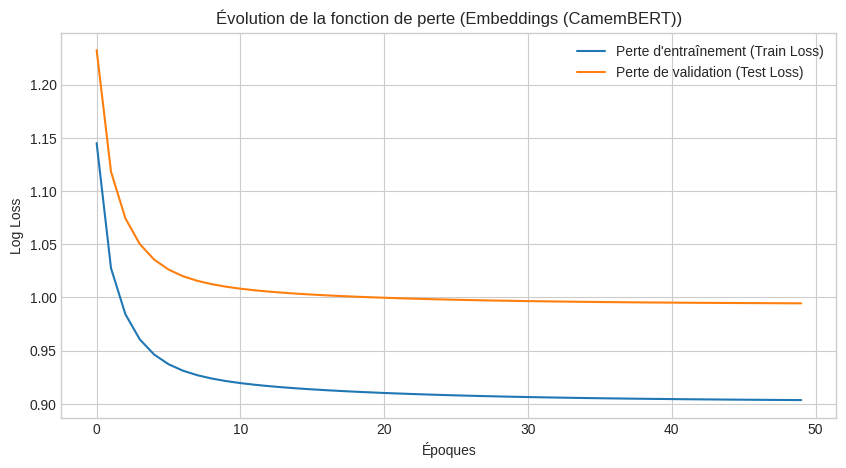

📊 Mean Absolute Error (MAE) finale: 24.9000\n


In [37]:
# Entraînement TF-IDF
#model_tfidf_sgd = train_with_loss_tracking(
#    X_train_tfidf, X_test_tfidf, 
#    train_labels, test_labels,
#    "TF-IDF",
#    n_epochs=30
#)

# Entraînement Embedings
model_embedding_sgd = train_with_loss_tracking(
    X_train_embedding, X_test_embedding,
    train_labels, test_labels,
    "Embeddings (CamemBERT)",
    n_epochs=50
)

In [38]:
def predict_random_text(test_dataset):
    """
    Sélectionne un texte aléatoire dans le jeu de données, le prédit avec les deux modèles
    et affiche une comparaison.
    """
    # 1. Sélectionner un exemple aléatoire
    random_index = random.randint(0, len(test_dataset) - 1)
    random_example = test_dataset[random_index]
    
    title = random_example.get('title', 'Titre non disponible')
    true_date = random_example.get('date', 'Date non disponible')
    full_text = random_example.get('complete_text', '')

    print(f"--- Interrogation d'un texte aléatoire ---")
    print(f"📚 Titre : {title}")
    print(f"🗓️  Date réelle : {true_date}")
    print("-" * 40)

    # 2. Nettoyer le texte comme pour l'entraînement
    # La fonction clean_text renvoie un dictionnaire, nous extrayons le texte
    cleaned_text_dict = clean_text(random_example)
    cleaned_text = cleaned_text_dict['text']
    
    # Le texte doit être dans une liste pour les transformateurs
    text_to_predict = [cleaned_text]

    # 3. Prédiction avec le modèle TF-IDF
    #tfidf_features = tfidf_vectorizer.transform(text_to_predict)
    #prediction_tfidf = model_tfidf_sgd.predict(tfidf_features)[0]
    #print(f"🤖 Prédiction (TF-IDF) : {prediction_tfidf}s")

    # 4. Prédiction avec le modèle Embeddings
    embedding_features = create_embeddings(text_to_predict, batch_size=1)
    prediction_embedding = model_embedding_sgd.predict(embedding_features)[0]
    print(f"🧠 Prédiction (Embeddings) : {prediction_embedding}s")
    print(f"----------------------------------------\\n")

In [39]:
predict_random_text(ds['train'])

--- Interrogation d'un texte aléatoire ---
📚 Titre : Oeuvres de Charles Nodier. T. 12
🗓️  Date réelle : 1832-1837
----------------------------------------
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

🧠 Prédiction (Embeddings) : 1850s
----------------------------------------\n


In [40]:

def test_and_plot_predictions(test_dataset, num_trials=15):
    """
    Sélectionne plusieurs textes aléatoires, prédit leur date avec deux modèles,
    et affiche un graphique comparatif des résultats.
    
    Args:
        test_dataset (list): La liste d'exemples à tester.
        num_trials (int): Le nombre d'essais à effectuer.
    """
    real_dates = []
    tfidf_predictions = []
    embedding_predictions = []

    print(f"--- Lancement de {num_trials} essais de prédiction ---")

    for i in range(num_trials):
        # 1. Sélectionner un exemple aléatoire
        random_example = random.choice(test_dataset)
        
        # Extrait la date et la convertit en entier pour le graphique
        # On suppose que la date est au format 'YYYYs' (ex: '1990s')
        try:
            true_date_str = random_example.get('date', '0s')
            true_date_int = int(true_date_str[:4]) # Convertit '1990s' en 1990
        except (ValueError, IndexError):
            print(f"Avertissement : impossible de parser la date '{true_date_str}'. Essai ignoré.")
            continue

        # 2. Nettoyer le texte
        cleaned_text = clean_text(random_example)['text']
        text_to_predict = [cleaned_text]

        # 3. Prédiction avec le modèle TF-IDF
        #tfidf_features = tfidf_vectorizer.transform(text_to_predict)
        #prediction_tfidf = model_tfidf_sgd.predict(tfidf_features)[0]

        # 4. Prédiction avec le modèle Embeddings
        embedding_features = create_embeddings(text_to_predict, batch_size=1)
        prediction_embedding = model_embedding_sgd.predict(embedding_features)[0]
        
        # 5. Stocker les résultats
        real_dates.append(true_date_int)
        #tfidf_predictions.append(prediction_tfidf)
        embedding_predictions.append(prediction_embedding)
        
        #print(f"Essai {i+1}/{num_trials} | Réel : {true_date_int} | TF-IDF : {prediction_tfidf} | Embeddings : {prediction_embedding}")
        print(f"Essai {i+1}/{num_trials} | Réel : {true_date_int} | Embeddings : {prediction_embedding}")

    # 6. Générer le graphique
    if not real_dates:
        print("Aucune donnée à afficher.")
        return

    trials = range(1, len(real_dates) + 1)
    
    plt.style.use('seaborn-v0_8-whitegrid') # Style visuel agréable
    plt.figure(figsize=(14, 7)) # Taille de la figure

    # Tracer chaque série de données
    plt.plot(trials, real_dates, 'o-', color='green', label='Date Réelle', markersize=8)
    #plt.plot(trials, tfidf_predictions, 's--', color='blue', label='Prédiction (TF-IDF)')
    plt.plot(trials, embedding_predictions, '^:', color='red', label='Prédiction (Embeddings)')

    # Ajouter les titres et les légendes
    plt.title('Comparaison des Prédictions de Date sur Plusieurs Essais', fontsize=16)
    plt.xlabel("Numéro de l'essai", fontsize=12)
    plt.ylabel("Date (Année)", fontsize=12)
    plt.xticks(trials) # Assure que chaque essai a une graduation sur l'axe X
    plt.legend(fontsize=10)
    plt.tight_layout() # Ajuste le graphique pour qu'il s'affiche bien

    # Afficher le graphique
    plt.show()

--- Lancement de 20 essais de prédiction ---
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


Essai 1/20 | Réel : 1896 | Embeddings : 1850
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Essai 2/20 | Réel : 1939 | Embeddings : 1900
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Essai 3/20 | Réel : 1783 | Embeddings : 1850
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


Essai 4/20 | Réel : 1885 | Embeddings : 1900
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Essai 5/20 | Réel : 1913 | Embeddings : 1850
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Essai 6/20 | Réel : 1852 | Embeddings : 1850
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Essai 7/20 | Réel : 1887 | Embeddings : 1850
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Essai 8/20 | Réel : 1829 | Embeddings : 1850
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Essai 9/20 | Réel : 1811 | Embeddings : 1850
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


Essai 10/20 | Réel : 1866 | Embeddings : 1850
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Essai 11/20 | Réel : 1871 | Embeddings : 1900
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Essai 12/20 | Réel : 1843 | Embeddings : 1850
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Essai 13/20 | Réel : 1912 | Embeddings : 1900
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Essai 14/20 | Réel : 1975 | Embeddings : 1850
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


Essai 15/20 | Réel : 1890 | Embeddings : 1900
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Essai 16/20 | Réel : 1865 | Embeddings : 1850
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Essai 17/20 | Réel : 1868 | Embeddings : 1850
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Essai 18/20 | Réel : 1863 | Embeddings : 1900
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


Essai 19/20 | Réel : 1791 | Embeddings : 1850
Création des embeddings pour 1 textes...


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

Essai 20/20 | Réel : 1821 | Embeddings : 1850


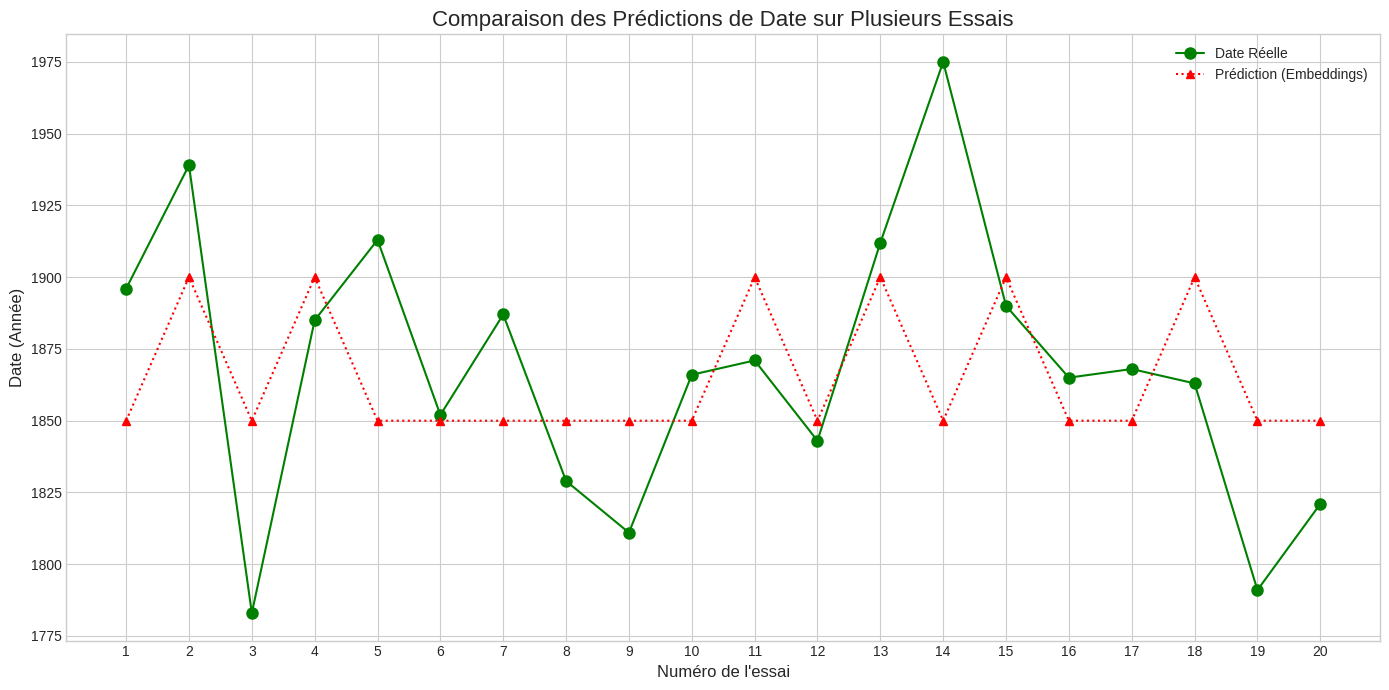

In [41]:
test_and_plot_predictions(ds['train'], num_trials=20)